# Action Client node for user interface with Jupyter 

### Import
Common imports

In [1]:
import rospy
import assignment_2_2023.msg
from assignment_2_2023.msg import GoalCoord
from assignment_2_2023.srv import CancelGoal, CancelGoalResponse
from turtlesim.msg import Pose
from nav_msgs.msg import Odometry
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

Other Imports

In [2]:
#import jupyros as jr
#from jupyros import ros3d
import os
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

### Init of the node

In [3]:
time.sleep(1)

# Initialize the node
rospy.init_node('user_interface')

# Goal insert by the user publisher
pubgoal = rospy.Publisher('/goal_coord', GoalCoord, queue_size=1)

# wait for the service to be available
rospy.wait_for_service('/cancel_goal')
cancgoalServ = rospy.ServiceProxy('/cancel_goal', CancelGoal)

welcText = widgets.Textarea(value='Hi, welcome to the robot planner simulation!!', layout=widgets.Layout(width='auto'))
display(welcText)

goalSet = [] # All goal set by the user
goalCanc = [] # All goal canceled by the user
goalReached = [] # All goal reached by the robot


Textarea(value='Hi, welcome to the robot planner simulation!!', layout=Layout(width='auto'))

## Odom subscription
Subscriber to check if the goal has been reached or not


In [4]:
def goal_reach_callback (msg):

    if goalSet and len(goalSet) > len(goalReached) + len(goalCanc):
        if msg.pose.pose.position.x - 0.5 < goalSet[-1][0] < msg.pose.pose.position.x + 0.5 and msg.pose.pose.position.y - 0.5 < goalSet[-1][1] < msg.pose.pose.position.y + 0.5:
            goalReached.append(goalSet[-1])
            print(goalReached)
            

subpos = rospy.Subscriber('/odom', Odometry, goal_reach_callback)

### User Interface
User Interface to set the goal

In [5]:
introText = widgets.Textarea(value='Please choose the goal position you want to reach with the robot.', 
                             layout=widgets.Layout(width='auto'))
display(introText)
xdes = widgets.Text(value='Choose the x coordinate:')
# widget to insert the x coordinate of the goal
xgoal = widgets.IntSlider(
    value = 0,
    min = -8,
    max = 8,
    step = 1,
    layout=widgets.Layout(width='auto')
)
display(xdes, xgoal)

# widget to insert the y coordinate of the goal
ydes = widgets.Text(value='Choose the y coordinate:')
ygoal = widgets.IntSlider(
    value = 0,
    min = -8,
    max = 8,
    step = 1,
    layout=widgets.Layout(width='auto')
)
display(ydes, ygoal)

# Button to send the goal to the robot
bttgoal = widgets.Button(description='Send goal', 
                         layout=widgets.Layout(width='auto', display='flex', justify_content='center'), 
                         style=widgets.ButtonStyle(button_color='red', font_weight='bold', color='white'))
box = widgets.Box([bttgoal])
box.layout = widgets.Layout(display='flex', justify_content='center', width='100%')
out = widgets.Output()
display(box, out)

# Function to send the goal to the robot
def on_button_clicked_set(b):
    with out:
        if xgoal.value == None or ygoal.value == None:
            print('Please insert a valid number')
        else:
            goal = GoalCoord()
            goal.coord_x = xgoal.value
            goal.coord_y = ygoal.value
            pubgoal.publish(goal)
            goalSet.append([xgoal.value, ygoal.value])
            print('Goal sent to the robot')

bttgoal.on_click(on_button_clicked_set)

Textarea(value='Please choose the goal position you want to reach with the robot.', layout=Layout(width='auto'…

Text(value='Choose the x coordinate:')

IntSlider(value=0, layout=Layout(width='auto'), max=8, min=-8)

Text(value='Choose the y coordinate:')

IntSlider(value=0, layout=Layout(width='auto'), max=8, min=-8)

Box(children=(Button(description='Send goal', layout=Layout(display='flex', justify_content='center', width='a…

Output()

User Interface to cancel the goal


In [6]:
# Text to cancel the latest goal
cancText = widgets.Textarea(value='Here you can cancel the the latest goal', 
                             layout=widgets.Layout(width='auto'))
display(cancText)

# Button to cancel the goal
bttcanc = widgets.Button(description='Cancel goal', 
                         layout=widgets.Layout(width='auto', display='flex', justify_content='center'), 
                         style=widgets.ButtonStyle(button_color='purple', font_weight='bold', color='black'))
boxcanc = widgets.Box([bttcanc])
boxcanc.layout = widgets.Layout(display='flex', justify_content='center', width='100%')
out = widgets.Output()
display(boxcanc, out)

# Function to cancel the goal when button is clicked
def on_button_clicked_canc(b):
    with out:
        if len(goalSet) == 0:
            print('No goal to cancel')
        else:
            status = cancgoalServ()
            # perform the control
            if (status.stat == "Done"):
                goalCanc.append(goalSet[-1])
                print('Goal ',goalCanc[-1][0], ' , ',goalCanc[-1][1], ' cancelled')
            elif (status.stat == "Reached"):
                print('Goal not cancelled becouse already reached')
            else:
                print('Goal not cancelled, error occoured')


bttcanc.on_click(on_button_clicked_canc)

Textarea(value='Here you can cancel the the latest goal', layout=Layout(width='auto'))

Box(children=(Button(description='Cancel goal', layout=Layout(display='flex', justify_content='center', width=…

Output()

### Graphical representation

Warning: The list containing the values for the graph, due to computer problems, must have a small size.  
Because of that, the graph will show only 100 points.

Graph to show the real time robot position in the environment.

In [7]:
%matplotlib widget
import matplotlib.pyplot as plt
import rospy
import tf
from tf.transformations import quaternion_matrix
import numpy as np
from matplotlib.animation import FuncAnimation

# Function to ensure that the two lists have the same length
def ensure_same_length(list1, list2):
    if len(list1) > len(list2):
        list1 = list1[:len(list2)]
    elif len(list2) > len(list1):
        list2 = list2[:len(list1)]
    return list1, list2

posText = widgets.Textarea(value='Robot real time position', layout=widgets.Layout(width='auto'))
xvalue = widgets.Textarea(value='', layout=widgets.Layout(width='auto'))
yvalue = widgets.Textarea(value='', layout=widgets.Layout(width='auto'))
display(posText)
display(xvalue)
display(yvalue)

# Class to visualize the robot position
class Visualiser:
	def __init__(self):
		self.fig, self.ax = plt.subplots()
		self.ln, = plt.plot([], [], 'ro')
		self.ln_goal, = plt.plot([], [], 'kD')
		self.x_data, self.y_data = [0]*100 , [0]*100
		self.index = 0
		self.goal_x, self.goal_y = 11, 11

		# Title and labels
		self.ax.set_title('Robot position')
		self.ax.set_xlabel('X axis')
		self.ax.set_ylabel('Y axis')

        # Use gridlines
		self.ax.grid(True)

	def plot_init(self):
		self.ax.set_xlim(-10, 10)
		self.ax.set_ylim(-10, 10)
		return self.ln,
		
	def odom_callback(self, msg):
		self.y_data[self.index] = msg.pose.pose.position.y
		self.x_data[self.index] = msg.pose.pose.position.x
		xvalue.value = 'x = ' + format(msg.pose.pose.position.x, '.3f')
		yvalue.value = 'y = ' + format(msg.pose.pose.position.y, '.3f')
		self.index = (self.index + 1) % 100

	def update_plot(self, frame):
		self.x_data, self.y_data = ensure_same_length(self.x_data, self.y_data)
		self.ln.set_data(self.x_data, self.y_data)
		if goalSet:
			if not goalReached or goalSet[-1] != goalReached[-1]:
				self.goal_x = goalSet[-1][0]
				self.goal_y = goalSet[-1][1]
			else:
				self.goal_x = 11
				self.goal_y = 11
	
		return self.ln, self.ln_goal

Textarea(value='Robot real time position', layout=Layout(width='auto'))

Textarea(value='', layout=Layout(width='auto'))

Textarea(value='', layout=Layout(width='auto'))

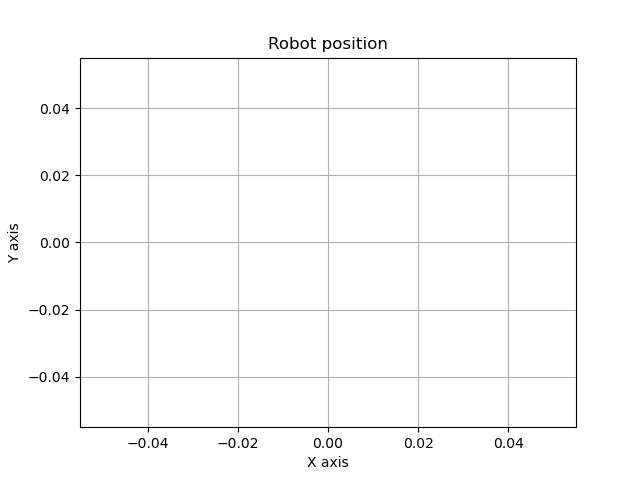

In [8]:
# Create the visualiser object
vis = Visualiser()
sub = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)
plt.show(block=True)

### Goal Reached vs Goal Canceled
This section of the user interface shows the statistic of the number of achieved, deleted and not yet achieved goals (corresponds to the goal set last that does not belong to either category). The statistic is displayed immediately after pressing the button.
This architecture derives from the idea that the goal statistics do not need to be updated continuously, but only at the moment when the user is interested in seeing the specific, instantaneous data without it being bypassed at an undesired moment.

In [9]:
# Showing the goal status
btthist = widgets.Button(description='Show histogram reached vs canceled vs not reached', 
                         layout=widgets.Layout(width='auto', display='flex', justify_content='center'), 
                         style=widgets.ButtonStyle(button_color='green', font_weight='bold', color='white'))
boxhist = widgets.Box([btthist])
boxhist.layout = widgets.Layout(display='flex', justify_content='center', width='100%')
out = widgets.Output()
display(boxhist, out)

def on_button_clicked_hist(b):
    with out:
        out.clear_output() # clear the older histogram
        plt.figure() # create a new figure
        set = len(goalSet)
        reached = len(goalReached)
        canc = len(goalCanc)
        not_reached = set - reached - canc
        index = np.arange(1);
        plt.bar(index, set, align='edge', width=0.3, alpha=0.40,
        color='b', label='Set')
        plt.bar(index+0.35, reached, align='edge', width=0.3,
        alpha=0.40, color='r', label='Reached')
        plt.bar(index+0.70, canc, align='edge', width=0.3,
        alpha=0.40, color='g', label='Canceled')
        plt.bar(index+1.05, not_reached, align='edge', width=0.3,
        alpha=0.40, color='y', label='Not Reached')

        plt.xlabel('Type of action')
        plt.ylabel('Number of goals')
        plt.title('Goal reached vs canceled vs not reached')
        plt.legend()
        plt.show()
        

btthist.on_click(on_button_clicked_hist)

Box(children=(Button(description='Show histogram reached vs canceled vs not reached', layout=Layout(display='f…

Output()

###